# Clustering Two Features

**Project Goal:** A model to cluster two features. A unsupervised model to segment the two categories of households - the credit fearful and the credit fearless groups, and to examine the differences between the two clusters. Also to examine the mean charactristics of the two clusters.

In [7]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils.validation import check_is_fitted

### Prepare Data

Import

- We create and use wrangle() function that takes a path of a CSV file as input, reads the file into a DataFrame, subsets the data to households that have been turned down for credit or feared being denied credit in the past 5 years (see "TURNFEAR"), and returns the subset DataFrame.

In [11]:
def wrangle(filepath):
    df=pd.read_csv(filepath)
    mask = df["TURNFEAR"] == 1
    df_fear = df[mask]
    
    return df

In [13]:
df=wrangle("data/customer.csv")
print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


Explore

Scatter Plot. Home Value vs Debt

- Here we explore the relationship between real estate and debt for the credit fearful households.

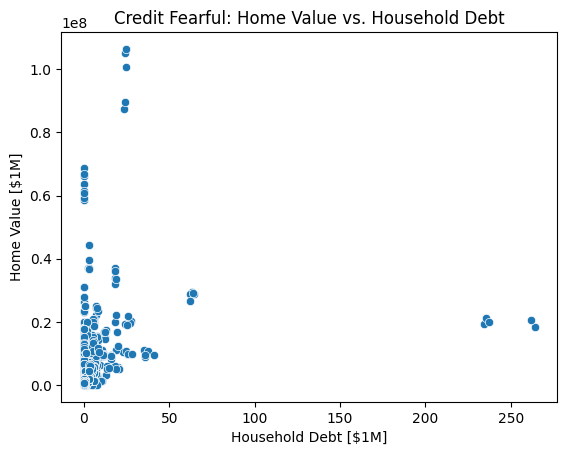

In [15]:
# Plot "HOUSES" vs "DEBT"
sns.scatterplot(x=(df["DEBT"]/1e6), y=df["HOUSES"])
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Split

Vertical split

In [16]:
X = df[["DEBT", "HOUSES"]]

print("X type:", type(X))
print("X shape:", X.shape)
X.head()

X type: <class 'pandas.core.frame.DataFrame'>
X shape: (28885, 2)


,DEBT,HOUSES
0,0.0,1100000.0
1,0.0,1100000.0
2,0.0,1100000.0
3,0.0,1100000.0
4,0.0,1100000.0


### Build Model

**Unsupervised Learning & KMeans** - Has no target matrix, only the feature matrix.

- Cluster households based on their proximity to eachh other. 
- K in KMeans is the number of clusters.